In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Points layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Labels layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
---------- in 
Add a Shapes layer to the layer list. 
...
  warn(msg)
/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/numpydoc/docscrape.py:449: UserWarning: potentially wrong underline length... 
Extended Summary 
-------

In [2]:
import liana as li

In [3]:
from matplotlib.pyplot import hist

In [4]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [5]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [6]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [7]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [8]:
adata.obsm['proximity'] = csr_matrix(weights)

In [9]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2", "Dnm1l"], "receptor":["Gucy1b3", "Mtor", "Tuba1a", "Fam63b"]})

In [32]:
dist = adata.obsm['proximity']

In [10]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [11]:
lr_res

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
0,Dnm1l&Gucy1b3,Dnm1l,Gucy1b3,Dnm1l,Gucy1b3,2.682889,0.950000,3.117442,0.976923,0.950000
1,Dnm1l&Fam63b,Dnm1l,Fam63b,Dnm1l,Fam63b,2.682889,0.950000,1.781250,0.830769,0.830769
2,Arrb1&Mtor,Arrb1,Mtor,Arrb1,Mtor,2.665413,0.957692,2.298451,0.907692,0.907692
3,Igf2&Tuba1a,Igf2,Tuba1a,Igf2,Tuba1a,1.924077,0.892308,6.466562,1.000000,0.892308


Correlations

masked

In [20]:
import scipy.stats as stats

In [21]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)
# x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [22]:
def masked_wcor(x, y, weight, method='spearman_nzw'):
    spot_n = x.shape[0]
    
    # reshape x and y to be the same shape as weight
    x = np.reshape(np.repeat(x, spot_n), newshape=(spot_n, spot_n)).T
    y = np.reshape(np.repeat(y, spot_n), newshape=(spot_n, spot_n)).T
    
    # mask x and y with the same mask as weight
    x_masked = np.ma.array(x, mask = weight.mask, fill_value=np.nan)
    y_masked = np.ma.array(y, mask = weight.mask, fill_value=np.nan)
    
    if method == 'spearman_nzw':
        x_masked = stats.mstats.rankdata(x_masked, axis=1)
        y_masked = stats.mstats.rankdata(y_masked, axis=1)
    
    # calculate weighted pearson correlation
    n1 = np.ma.sum(weight, axis=1) * np.ma.sum(weight * x_masked * y_masked, axis=1)
    n2 = np.ma.sum(weight * x_masked, axis=1) * np.ma.sum(weight * y_masked, axis=1)
    numerator = n1 - n2
    
    denominator_x = np.ma.sum(weight, axis=1) * np.ma.sum(weight * x_masked**2, axis=1) - np.ma.sum(weight * x_masked, axis=1)**2
    denominator_y = np.ma.sum(weight, axis=1) * np.ma.sum(weight * y_masked**2, axis=1) - np.ma.sum(weight * y_masked, axis=1)**2
    wcor = numerator / np.ma.sqrt(denominator_x * denominator_y)
    
    return wcor.data

In [67]:
def calculate_masked_correlations(x_mat, y_mat, dist, method='spearman_nzw'):
    weight = dist.A
    msk = np.logical_not(weight>0).astype(np.int16)
    weight = np.ma.masked_array(dist.A, mask=msk)
    
    # calculate for each x and y combination
    local_correlations = []
    for i in range(x_mat.shape[0]):
        local_correlations.append(masked_wcor(x_mat[i, :], y_mat[i, :], weight))
    local_correlations = np.array(local_correlations)
    
    return local_correlations

In [47]:
masked_sp = calculate_masked_correlations(ligand_mat, receptor_mat, adata.obsm['proximity'], method='spearman_nzw')[0:5]

Fully-vectorized

In [26]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [27]:
import liana as li

In [28]:
from matplotlib.pyplot import hist

In [29]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [30]:
from scipy.stats import rankdata

In [31]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [33]:
def calculate_local_correlations(x_mat, y_mat, dist, method="pearson"):
    if method not in ["pearson", "spearman"]:
        raise ValueError("method must be one of 'pearson', 'spearman'")
    
    weight = dist.A.T ## does it really need to be A?
    weight_sums = np.sum(weight, axis = 0).flatten()
        
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
    
    # standard pearson
    n1 = (((x_mat * y_mat).dot(weight)) * weight_sums)
    n2 = (x_mat.dot(weight)) * (y_mat.dot(weight))
    numerator = n1 - n2
    
    denominator_x = (weight_sums * (x_mat ** 2).dot(weight)) - (x_mat.dot(weight))**2
    denominator_y = (weight_sums * (y_mat ** 2).dot(weight)) - (y_mat.dot(weight))**2
    
    local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))
    
    return local_corrs

In [34]:
local_pc = calculate_local_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="pearson")
local_sp = calculate_local_correlations(x_mat = ligand_mat.A, y_mat=receptor_mat.A, dist=dist, method="spearman")

In [35]:
local_pc.shape

(4, 260)

(array([ 9., 25., 27., 37., 26., 43., 37., 35., 14.,  7.]),
 array([-0.58677485, -0.4509323 , -0.31508976, -0.17924721, -0.04340467,
         0.09243788,  0.22828043,  0.36412297,  0.49996552,  0.63580806,
         0.77165061]),
 <BarContainer object of 10 artists>)

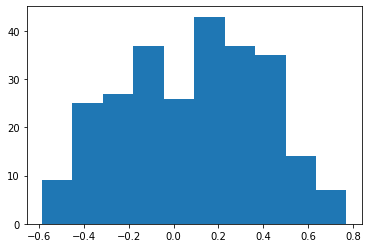

In [36]:
hist(local_pc[0,:])

local p-values

In [37]:
from numpy import random
from tqdm import tqdm

In [100]:
rng = random.default_rng(0)
n_perm = 1000
positive_only = True # remove this option?

In [101]:
local_pc.shape

(4, 260)

In [114]:
def _get_local_permutation_pvals(x_mat, y_mat, local_truth, function, dist, n_perm, positive_only=True, **kwargs):
    xy_n = local_truth.shape[0]
    spot_n = local_truth.shape[1]
    
    # permutation cubes to be populated
    local_pvals = np.zeros((xy_n, spot_n))
    
    # shuffle the matrix
    for i in tqdm(range(n_perm)):
        _idx = rng.permutation(spot_n)
        perm_r = function(x_mat = x_mat[:, _idx], y_mat=y_mat, dist=dist, **kwargs)
        if positive_only:
            local_pvals += np.array(perm_r >= local_truth, dtype=int)
        else:
            local_pvals += (np.array(np.abs(perm_r) >= np.abs(local_truth), dtype=int))

    local_pvals = local_pvals / n_perm
    
    return local_pvals
    

In [106]:
local_pvals = _get_local_permutation_pvals(ligand_mat.A, receptor_mat.A, local_pc, calculate_local_correlations, dist, n_perm, positive_only=True)

100%|██████████| 1000/1000 [00:01<00:00, 534.37it/s]


In [123]:
from  scipy.sparse import csr_matrix

In [82]:
local_pc.shape

(4, 260)

In [83]:
local_pvals.shape

(4, 260)

In [108]:
local_masked_pvals = _get_local_permutation_pvals(ligand_mat.A, receptor_mat.A, masked_sp, calculate_masked_correlations, dist, 100, positive_only=True)

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


In [116]:
masked_sp

array([[ 0.14309412,  0.05121768,  0.25515995, ..., -0.06165649,
        -0.43638704,  0.00177371],
       [-0.10581333,  0.29360736,  0.04407926, ...,  0.14110754,
         0.66784794,  0.14062116],
       [ 0.22754111,  0.4422745 ,  0.23457444, ..., -0.52143721,
         0.03018619,  0.27545886],
       [ 0.85488609,  0.78266451,  0.85818871, ...,  0.45052658,
         0.38507613,  0.84839006]])

In [110]:
local_masked_pvals.shape

(4, 260)